## Import Modules

In [45]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from sqlalchemy import create_engine

# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

## Get Labor Data

In [90]:
import pandas as pd
# Import the data
#!--------------------------------------------------------------------

labor = pd.read_csv(r'C:\Users\andre.davis\OneDrive - Power Stop, LLC\Documents\PROCESS ENG\1 - PROJECTS\WORKFORCE PLANNING\Staffing Data From Kathryn\df\labor.csv')
operationslabor = labor[labor['department']=='operations']
#!--------------------------------------------------------------------

df = operationslabor[['name','Date']].copy()
df['Date'] = pd.to_datetime(df['Date'])
# Set the date as index and rename column
df = df.set_index('Date')
df.columns = ['Labor']
# Select the proper time period for weekly aggreagation
df = df['2020-01-02':'2023-02-15'].resample('W').count()
df.head()

,Labor
Date,
2020-01-05 00:00:00+00:00,28
2020-01-12 00:00:00+00:00,0
2020-01-19 00:00:00+00:00,3
2020-01-26 00:00:00+00:00,3
2020-02-02 00:00:00+00:00,0


## Visualize Data
Get an overview of pattern & trend

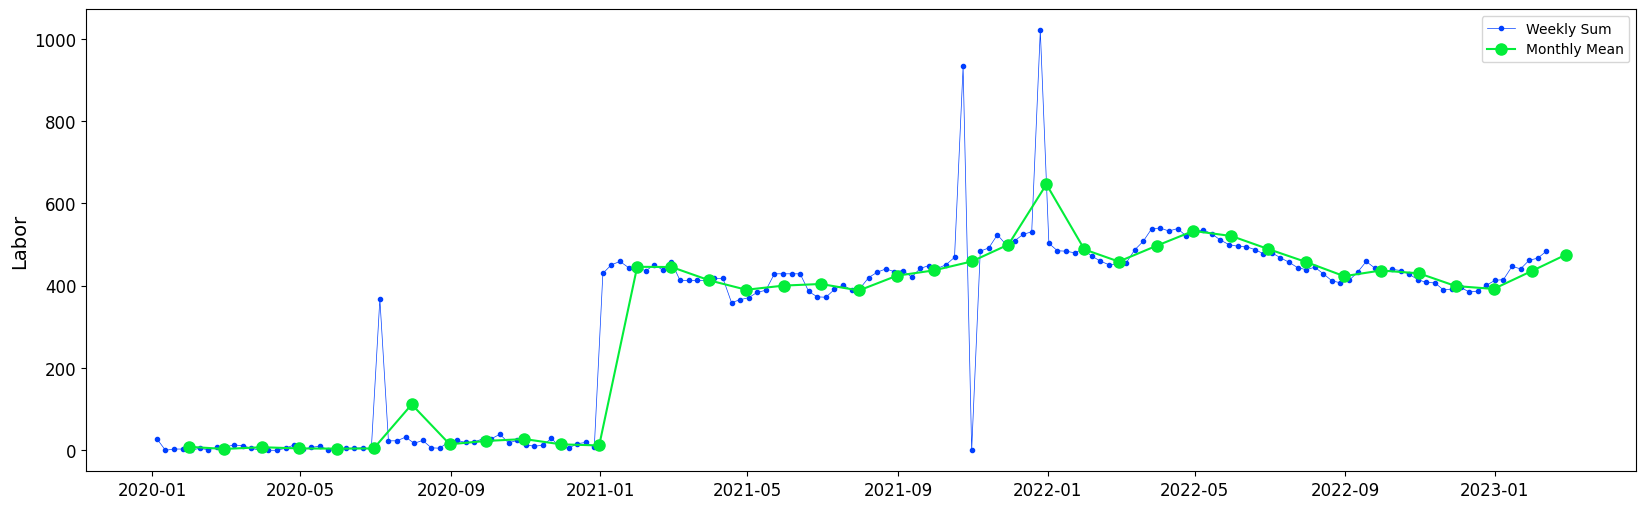

In [47]:
import warnings
import matplotlib.pyplot as plt
y = df['Labor']
fig, ax = plt.subplots(figsize=(20, 6))
plt.ticklabel_format(style='plain')
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly Sum')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean')
ax.set_ylabel('Labor')
ax.legend();

## Decomposing the Data
See more complexity behind the linear visualization

In [48]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

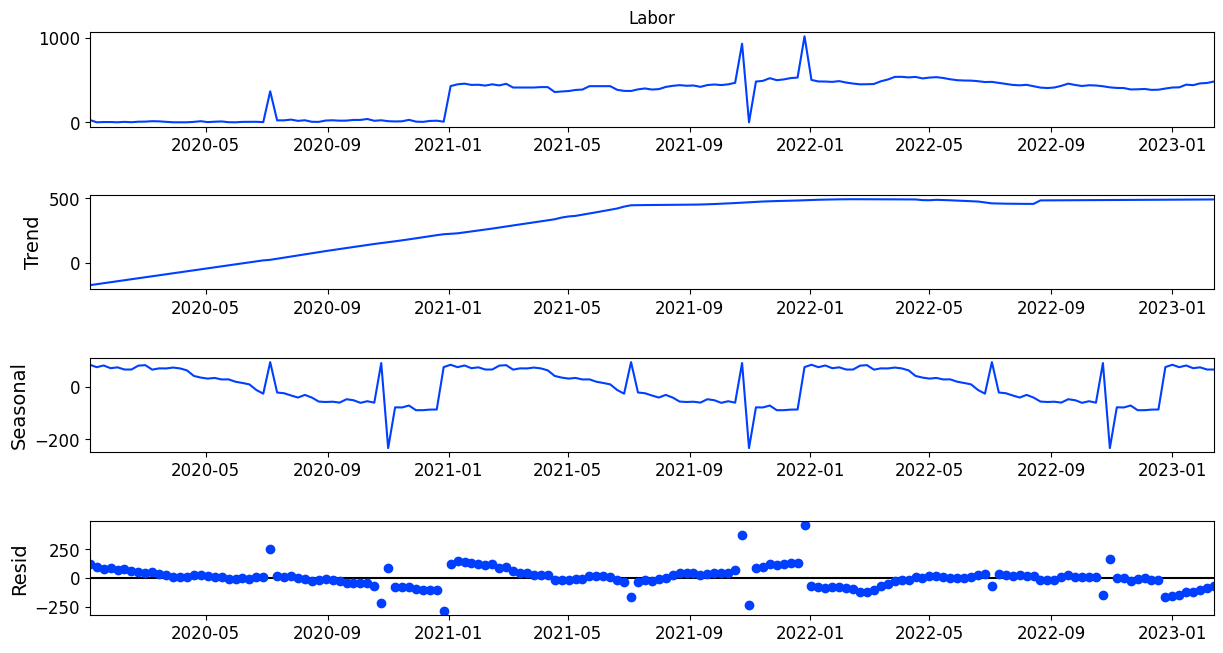

In [49]:
seasonal_decompose(y)

## Checking Stationarity
Next, we need to check whether the dataset is stationary or not. A dataset is stationary if its statistical properties like mean, variance, and autocorrelation do not change over time.
Most time series datasets related to business activity are not stationary since there are usually all sorts of non-stationary elements like trends and economic cycles. But, since most time series forecasting models use stationarity—and mathematical transformations related to it—to make predictions, we need to ‘stationarize’ the time series as part of the process of fitting a model.
Two common methods to check for stationarity are Visualization and the Augmented Dickey-Fuller (ADF) Test.

### Visualization: Graphing the rolling statistics

In [50]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    

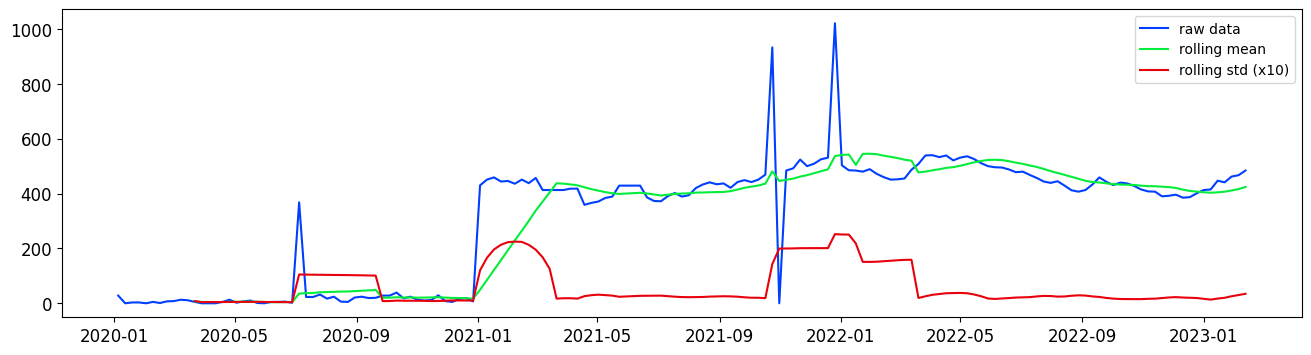

In [51]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

### Augmented Dickey-Fuller Test
Interpretation: When p-value > 0.05: The data has a unit root and is non-stationary.

In [52]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))


In [53]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -1.505
P-value = 0.531
Critical values :
	1%: -3.473542528196209 - The data is not stationary with 99% confidence
	5%: -2.880497674144038 - The data is not stationary with 95% confidence
	10%: -2.576878053634677 - The data is not stationary with 90% confidence


## Make the Data Stationary

There is a need to stationarize the dataset. We’ll use de-trending, differencing, and then a combination of the two.


### Detrending
This method removes the underlying trend in the time series:

 > Is the de-trended data stationary ?
Test statistic = -4.531
P-value = 0.000
Critical values :
	1%: -3.4756368462466662 - The data is  stationary with 99% confidence
	5%: -2.8814104466172608 - The data is  stationary with 95% confidence
	10%: -2.5773652982553568 - The data is  stationary with 90% confidence


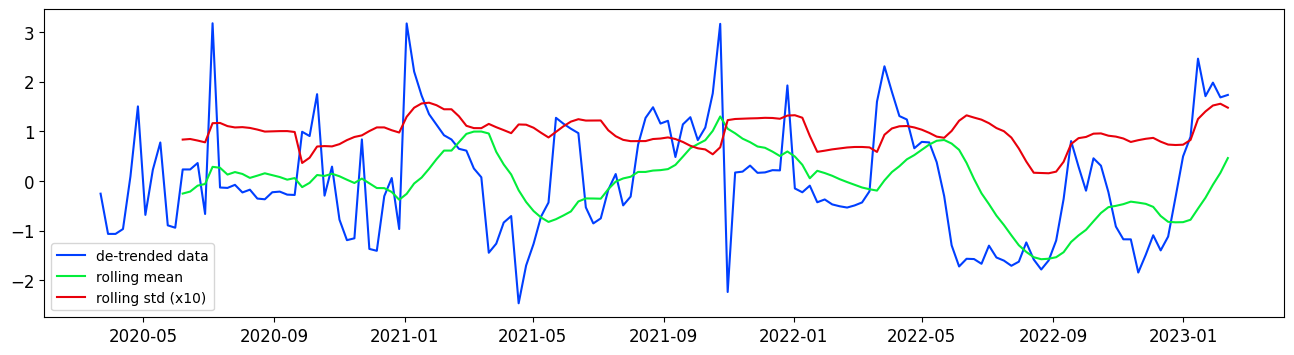

In [54]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

### Differencing

This method removes the underlying seasonal or cyclical patterns in the time series. Since the sample dataset has a 12-month seasonality, I used a 12-lag difference:

 > Is the 12 lag differenced data stationary ?
Test statistic = -3.360
P-value = 0.012
Critical values :
	1%: -3.47864788917503 - The data is not stationary with 99% confidence
	5%: -2.882721765644168 - The data is  stationary with 95% confidence
	10%: -2.578065326612056 - The data is  stationary with 90% confidence


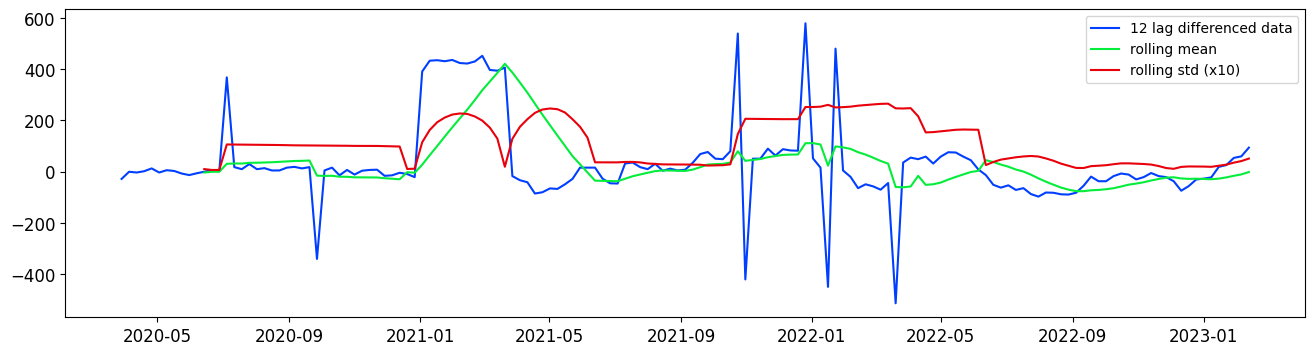

In [55]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

### Combining Detrending and Differencing
This approach uses both methods to stationarize the data.

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -2.565
P-value = 0.101
Critical values :
	1%: -3.482920063655088 - The data is not stationary with 99% confidence
	5%: -2.884580323367261 - The data is not stationary with 95% confidence
	10%: -2.5790575441750883 - The data is not stationary with 90% confidence


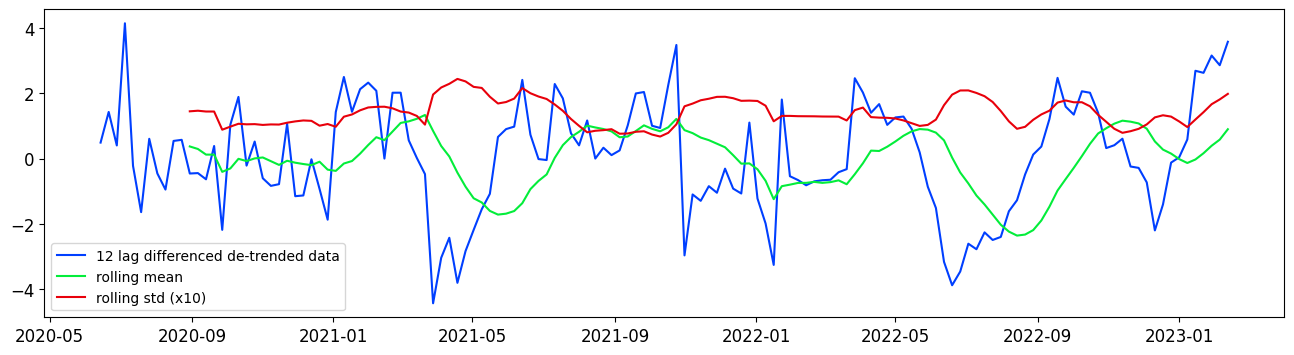

In [56]:
# Detrending + Differencing

y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')
ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

# Create Training & Testing Datasets

## Set the y_to_train, y_to_test, and the length of predict units 

In [57]:
y_to_train = y[:'2022-05-29'] # dataset to train
y_to_val = y['2022-06-05':] # last X months for test  
predict_date = len(y) - len(y[:'2022-06-05']) # the number of data points for the test set

# Prediction Model

### SARIMA
Seasonal Autoregressive Integrated Moving Average. Suitable for time series data with trend and/or seasonal components.

In [58]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [59]:
sarima_grid_search(y,52)

The set of parameters with the minimum AIC is: SARIMA(0, 1, 1)x(1, 1, 1, 52) - AIC:629.3643844100804


In [95]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                #enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    
    pred = results.get_prediction(start=pd.to_datetime(pred_date).tz_convert('US/Eastern'), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date).tz_convert('US/Eastern'), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5239      0.067     -7.865      0.000      -0.654      -0.393
ar.S.L52      -0.9969      0.002   -429.683      0.000      -1.001      -0.992
ma.S.L52       0.8082      0.072     11.222      0.000       0.667       0.949
sigma2      4200.5669   1.84e-05   2.28e+08      0.000    4200.567    4200.567


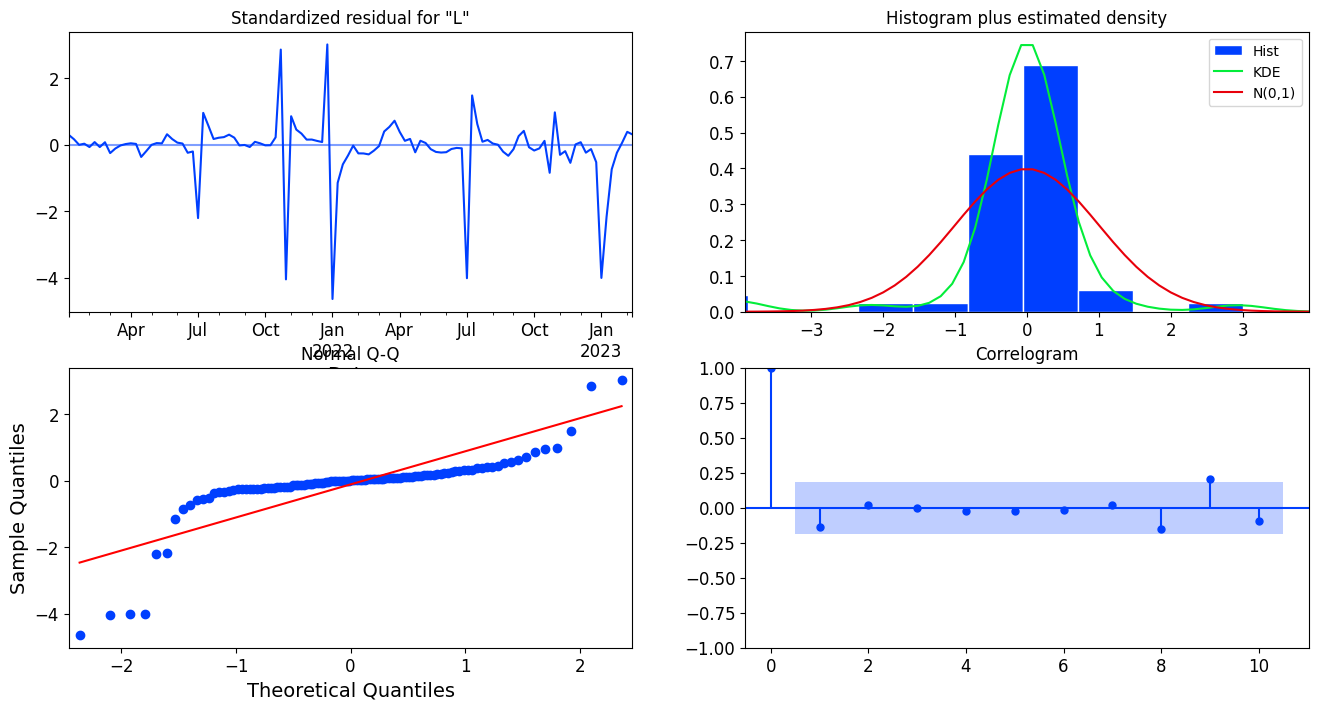

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 85.58


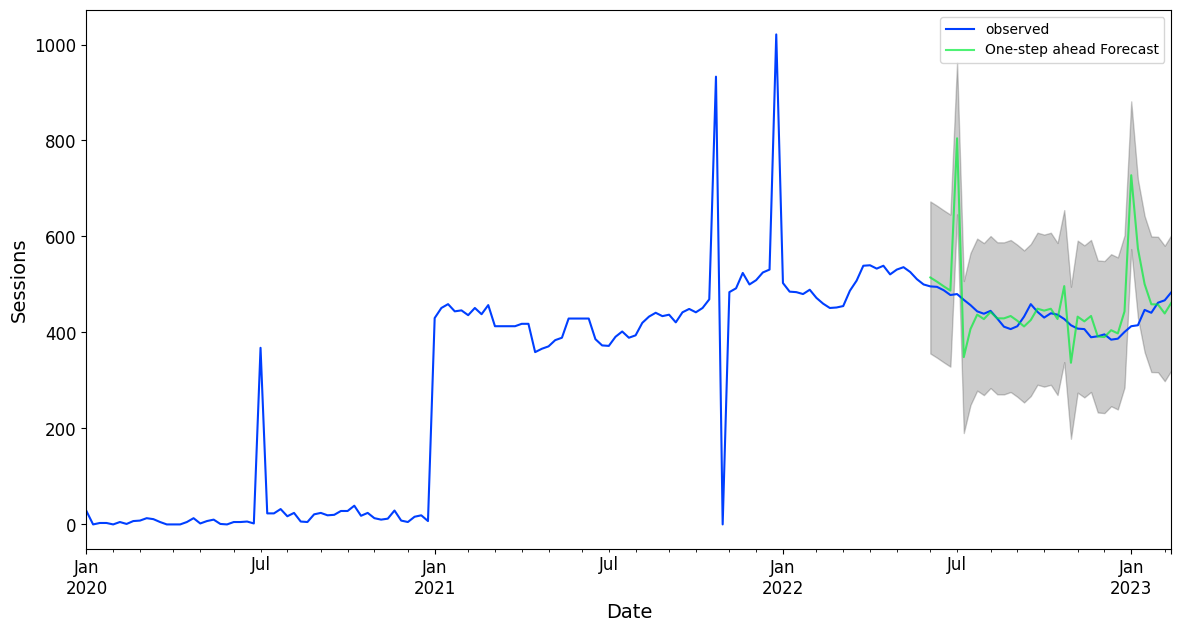

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 229.21


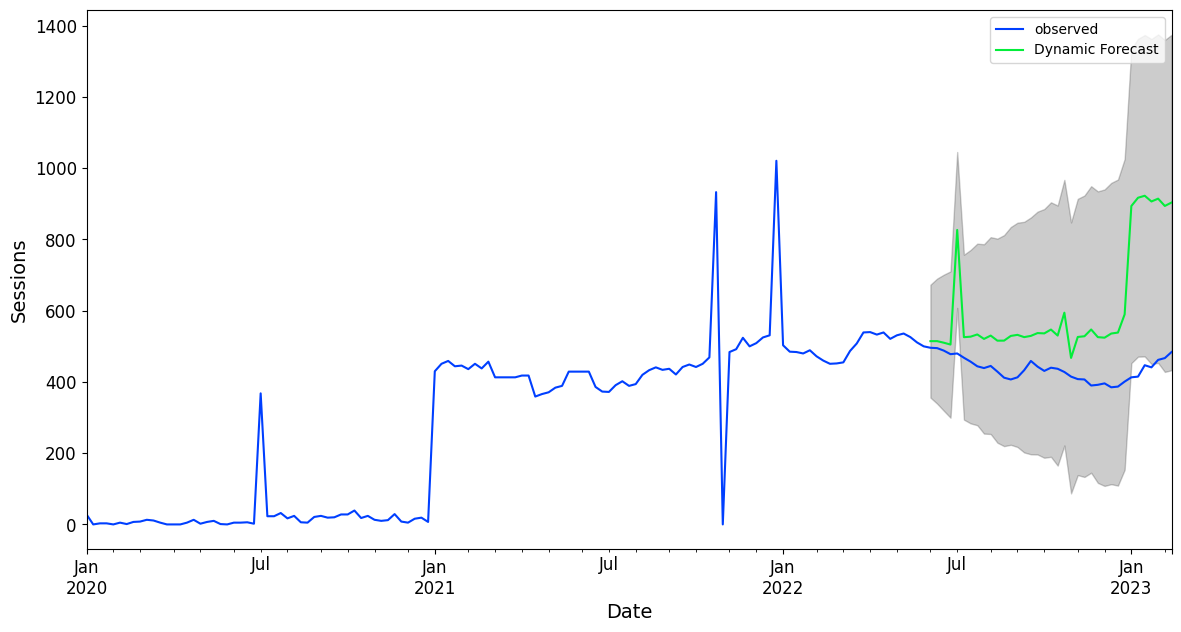

In [96]:
model = sarima_eva(y,(0, 1, 1),(1, 1, 1, 52),52,'2022-06-05 00:00:00+00:00',y_to_val)

In [97]:
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)

    #SARIMAXResults.conf_int, can change alpha,the default alpha = .05 returns a 95% confidence interval.
    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

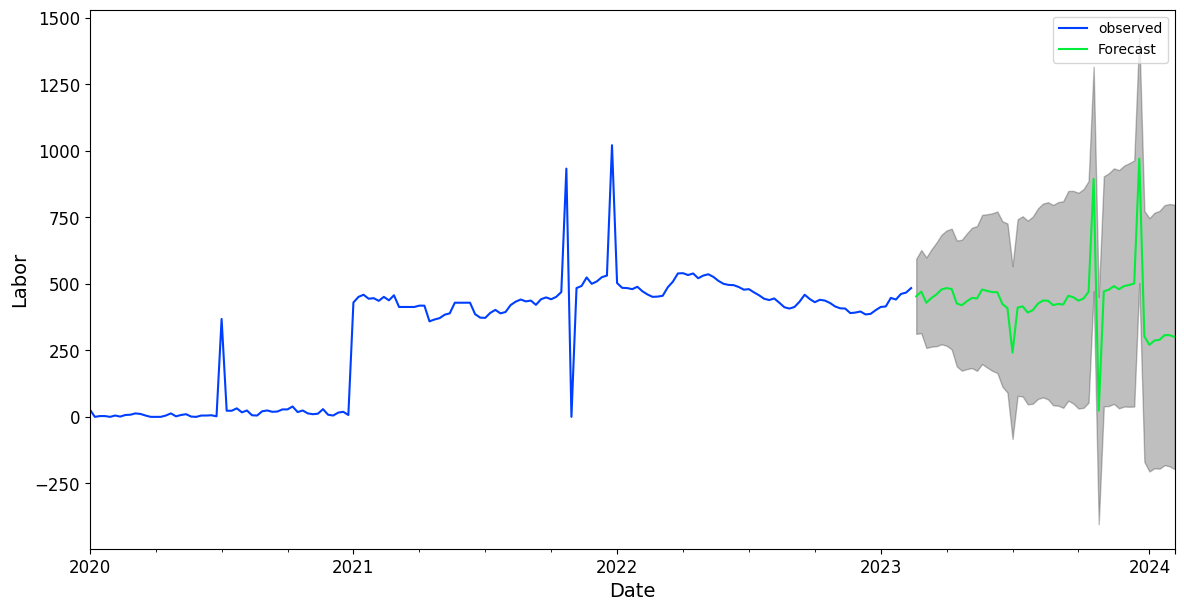

,Date,Predicted_Mean,Lower Bound,Upper Bound
0,2023-02-19 00:00:00+00:00,453.02270697,311.95737271,594.08804123
1,2023-02-26 00:00:00+00:00,470.76316606,314.51124959,627.01508253
2,2023-03-05 00:00:00+00:00,429.02799762,258.94704382,599.10895142
3,2023-03-12 00:00:00+00:00,446.62860234,263.76145407,629.49575060
4,2023-03-19 00:00:00+00:00,460.32281715,265.50686049,655.13877381


In [98]:
final_table = forecast(model,52,y)
final_table.head()

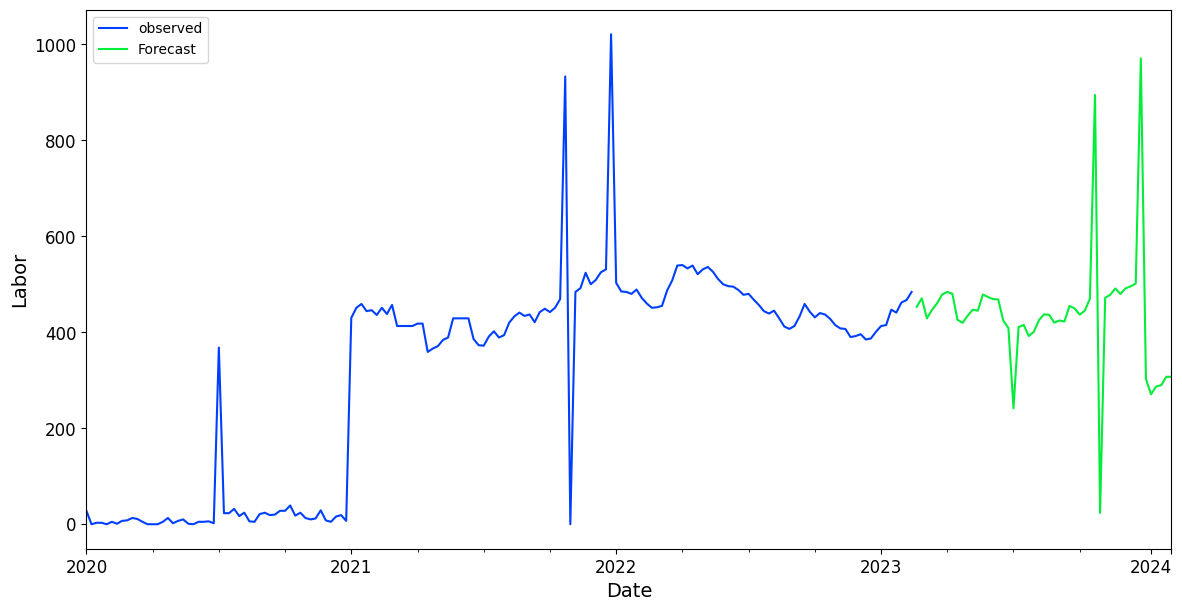

In [99]:
### Graphs without the confident interval 
pred_uc = model.get_forecast(steps=51)
ax = y.plot(label='observed', figsize=(14, 7))
#     print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

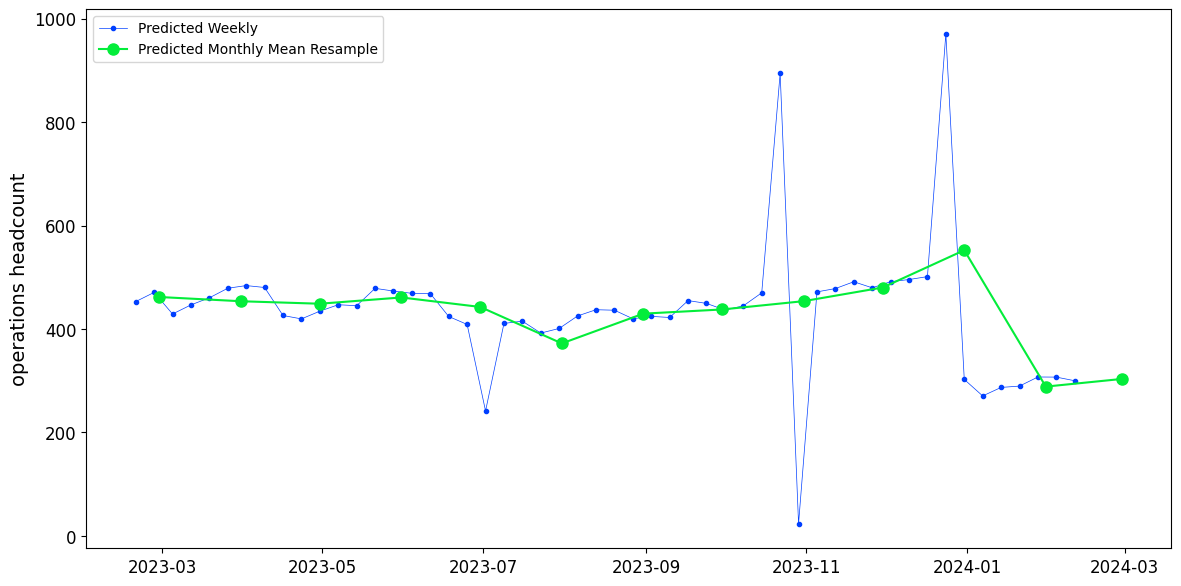

In [101]:
### Graphs show only the predicted period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
plt.ticklabel_format(style='plain')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('operations headcount')
ax.legend();